In [7]:
import pandas as pd

In [8]:
#Importando o arquivo já tratado atráves do excel, aonde fiz o tratamento dos dados substituindo os traços por "NA",  e fiz a codificação de algumas variáveis
#Troquei os valores sim e não, por 1 e 2

data = pd.ExcelFile("Base_MUNIC_2023.xlsx")

In [11]:
dataf = pd.read_excel("Base_MUNIC_2023.xlsx", sheet_name="Segurança Pública")

In [13]:
#Melhorando nome de algumas colunas

mapa_nomes = {
    'CodMun': 'cod_municipio_ibge',
    'Mun': 'nome_municipio',
    'PopMun': 'populacao',
    'Regiao': 'regiao',
    'MSEG03': 'sexo_gestor',
    'Delegacia especializada no Atendimento à Mulher': 'possui_deam',
    'MSEG27': 'possui_guarda_municipal',
    'MSEG282': 'efetivo_mulheres_guarda',
    'MSEG283': 'efetivo_total_guarda',
    'MSEG3119': 'capacitacao_violencia_genero'
}
dataf.rename(columns=mapa_nomes, inplace=True)

Colunas principais renomeadas.


In [14]:
#Especificando colunas que irão ser utilizadas

colunas_que_vou_usar = [
    'cod_municipio_ibge',
    'nome_municipio',
    'populacao',
    'regiao',
    'sexo_gestor',
    'possui_deam',
    'possui_guarda_municipal',
    'efetivo_mulheres_guarda',
    'efetivo_total_guarda',
    'capacitacao_violencia_genero'
]

In [15]:
#Criando novo Df com as colunas

df = dataf[colunas_que_vou_usar].copy()

In [18]:
#Alterando o tipo das colunas de cód do municipio e população

df[['cod_municipio_ibge','populacao']] = df[['cod_municipio_ibge','populacao']].astype('str')

In [21]:
#Verificando os tipos de cada coluna

df.dtypes

cod_municipio_ibge              object
nome_municipio                  object
populacao                       object
regiao                          object
sexo_gestor                     object
possui_deam                      int64
possui_guarda_municipal         object
efetivo_mulheres_guarda         object
efetivo_total_guarda            object
capacitacao_violencia_genero    object
dtype: object

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

### *Comparando a importâcia da Delegacia da Mulher em relação a outras delegacias especializadas*

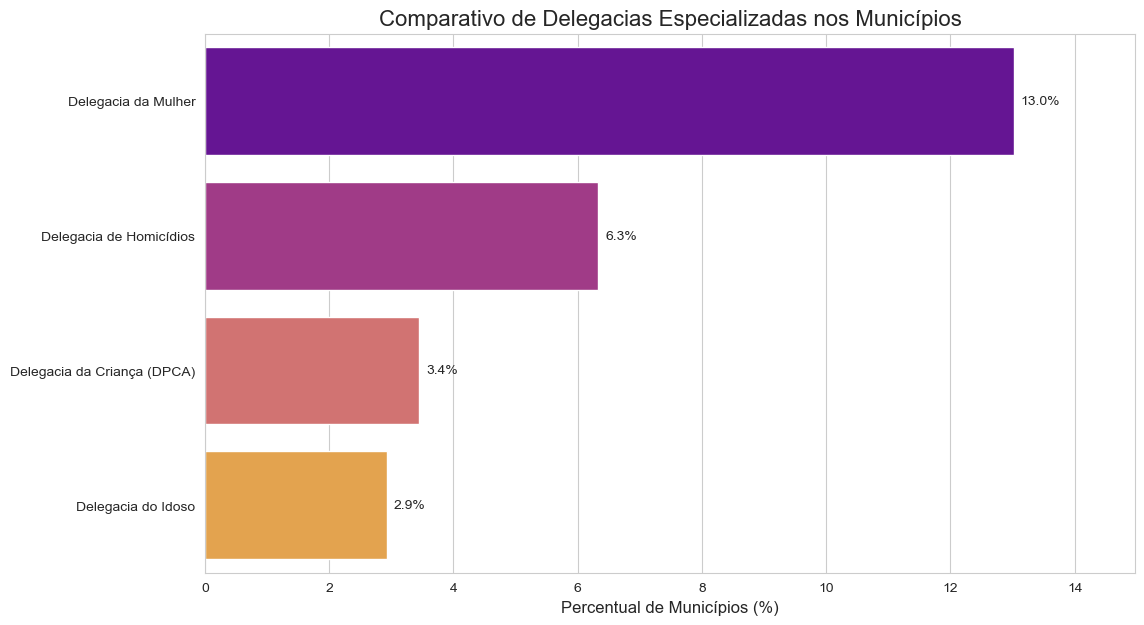

In [111]:
colunas_delegacias = {
    'possui_deam': 'Delegacia da Mulher',
    'Delegacia do Idoso': 'Delegacia do Idoso',
    'Delegacia da Criança (DPCA)': 'Delegacia da Criança (DPCA)',
    'Delegacia de Homicídios': 'Delegacia de Homicídios'
}

resultados = {}

for coluna_nome, nome_bonito in colunas_delegacias.items():
    if coluna_nome in dataf.columns:
        if dataf[coluna_nome].dtype in ['int64', 'float64']:
            respostas_sim = (dataf[coluna_nome] == 1).sum()
            respostas_validas = dataf[coluna_nome].isin([1, 2]).sum()
        else:
            respostas_sim = (dataf[coluna_nome] == 'Sim').sum()
            respostas_validas = dataf[coluna_nome].isin(['Sim', 'Não']).sum()
            
        if respostas_validas > 0:
            percentual = (respostas_sim / respostas_validas) * 100
            resultados[nome_bonito] = percentual
        else:
            resultados[nome_bonito] = 0
            
dados_grafico = pd.Series(resultados).sort_values(ascending=False)


sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

ax = sns.barplot(x=dados_grafico.values, y=dados_grafico.index, hue=dados_grafico.index, palette='plasma', legend=False)

plt.title('Comparativo de Delegacias Especializadas nos Municípios', fontsize=16)
plt.xlabel('Percentual de Municípios (%)', fontsize=12)
plt.ylabel('')

if not dados_grafico.empty and dados_grafico.max() > 0:
    plt.xlim(0, dados_grafico.max() * 1.15)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}%', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points')

plt.show()

### *Análise 1: Cobertura de Delegacias da Mulher (DEAMs) por Região e Percentual de mulheres na guarda*

#### *Agrupando as regiões e pegando o porcentual de cada*

In [49]:

total_municipios = df.groupby('regiao').size()
municipios_com_deam = df[df['possui_deam'] == 1].groupby('regiao').size()
percentual_por_regiao = (municipios_com_deam / total_municipios) * 100
percentual_por_regiao = percentual_por_regiao.round(2).sort_values(ascending=False)

percentual_por_regiao

regiao
3 - Sudeste         14.21
1 - Norte           12.44
5 - Centro-Oeste    11.13
4 - Sul              7.89
2 - Nordeste         6.24
dtype: float64

#### *Criando Gráfico do porcentual de cada região*

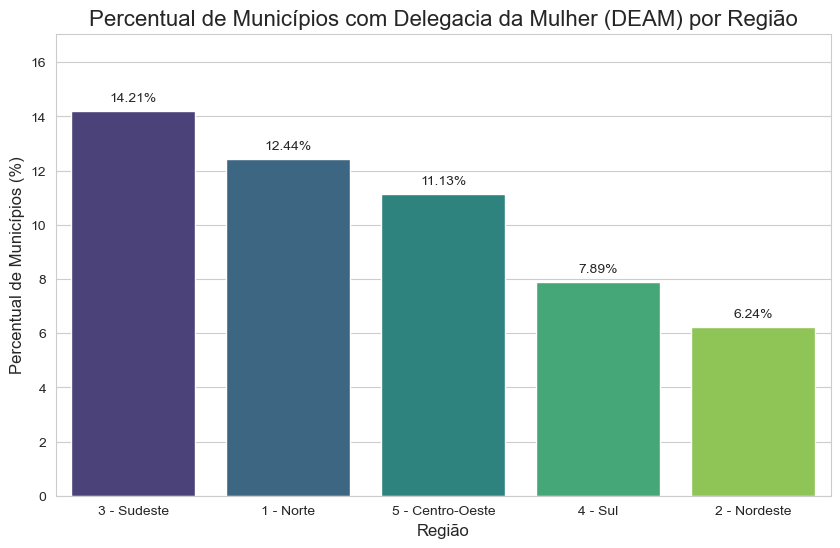

In [91]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x=percentual_por_regiao.index, 
    y=percentual_por_regiao.values,
    hue=percentual_por_regiao.index,
    palette='viridis', 
    legend=False
)

plt.title('Percentual de Municípios com Delegacia da Mulher (DEAM) por Região', fontsize=16)
plt.ylabel('Percentual de Municípios (%)', fontsize=12)
plt.xlabel('Região', fontsize=12)
plt.ylim(0, max(percentual_por_regiao.values) * 1.2)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

#### *Percentual de Mulheres na Guarda transformado em gráfico*

In [73]:
df['efetivo_mulheres_guarda'] = pd.to_numeric(df['efetivo_mulheres_guarda'], errors='coerce')
df['efetivo_total_guarda'] = pd.to_numeric(df['efetivo_total_guarda'], errors='coerce')
df_com_guarda = df[df['possui_guarda_municipal'] == 1].copy()
df_com_guarda['percentual_mulheres'] = (df_com_guarda['efetivo_mulheres_guarda'] / df_com_guarda['efetivo_total_guarda']) * 100

In [76]:
df['percentual_mulheres'] = (df['efetivo_mulheres_guarda'] / df['efetivo_total_guarda']) * 100


media_percentual_mulheres = df.groupby('regiao')['percentual_mulheres'].mean().sort_values(ascending=False)

media_percentual_mulheres

regiao
1 - Norte           15.805129
3 - Sudeste         15.091931
4 - Sul             14.364199
5 - Centro-Oeste    13.272518
2 - Nordeste        10.019824
Name: percentual_mulheres, dtype: float64

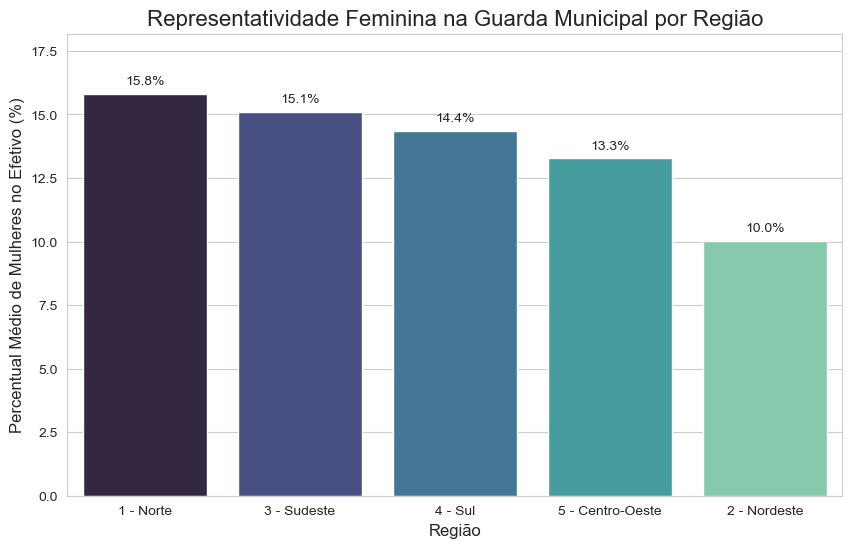

In [92]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=media_percentual_mulheres.index, y=media_percentual_mulheres.values, 
                 hue=media_percentual_mulheres.index, palette='mako', legend=False)



plt.title('Representatividade Feminina na Guarda Municipal por Região', fontsize=16)
plt.ylabel('Percentual Médio de Mulheres no Efetivo (%)', fontsize=12)
plt.xlabel('Região', fontsize=12)
plt.ylim(0, max(media_percentual_mulheres.values) * 1.15)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show()


### Análise a partir dos dados
_____________________

Análise Descritiva da Estrutura de Segurança Pública para Mulheres (MUNIC 2023)

Ao analisar os dados sobre Segurança Pública voltada para as mulheres no Brasil disponibilizados nos dados da MUNIC 2023

A primeira coisa que notei é que a Delegacia da Mulher se destaca na frente das outras. Ela existe em 13% dos municípios, uma diferença de 6,7 pontos percentuais para a segunda mais comum, que é a voltada para crianças.

Olhando por região, a situação muda. Sudeste (14,21%), Norte (12,44%) e Centro-Oeste (11,13%) são as que têm a maior cobertura de Delegacias da Mulher. A região Sul, em quarto lugar, já apresenta uma queda considerável na cobertura.

Por fim, quando o foco é a representatividade de mulheres na Guarda Municipal, o ranking muda de novo. O Norte passa para a primeira posição, com 15,80% de mulheres no efetivo, seguido pelo Sudeste (15,09%) e Sul (14,36%). isso indica que a presença feminina na guarda municipal não segue o mesmo padrão regional da existência das delegacias especializadas.